In [1]:
import os
import glob
import tempfile
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # uncomment for cpu

from itertools import cycle
from collections import Counter as ct

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2



import sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,LabelBinarizer,OneHotEncoder


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
seed =1337

In [12]:
path = ""#"Please copy the file location here whilst using doblue back slashes "\\" for directory seperation""



all_files = glob.glob(os.path.join(path, "*.csv"))
df1_from_each_file = (pd.read_csv(f) for f in all_files)
df1   = pd.concat(df1_from_each_file, ignore_index=True)


In [13]:
try:
    df1_temp = df1.loc[:,["CD66","CD45","CD16","CD3","CD19","CD27","CD8","CD4","CD14","HLADR","CD56","Species"]]
    species = set(df1_temp['Species'])
except:
    print ("""Please provide all the markers from following list:
    CD66,
    CD45,
    CD16,
    CD3,
    CD19,
    CD27,
    CD8,
    CD4,
    CD14,
    HLADR,
    CD56,
    Species""")

# Data Prep

In [14]:
df1_s = df1_temp.pop('Species')
# One Hot Encoding
spec_enc = LabelEncoder()
integer_encoded = spec_enc.fit_transform(df1_s)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# join the dataframes
df1_temp = df1_temp.join(pd.DataFrame(onehot_encoded,columns=spec_enc.classes_))
df1_temp

n_features = 14
# Create empy columns for missing species
if df1_temp.shape[1] != 14:
    all_species = {"H","M","R"}
    for i in all_species:
        if i not in species:
            df1_temp[i]= 0

#Order them   
df1_temp = df1_temp.loc[:,["CD66","CD45","CD16","CD3","CD19","CD27","CD8","CD4","CD14","HLADR","CD56","H","M","R"]]




In [15]:
# Create the network

model =  keras.models.load_model('./model/')


In [17]:
predictions = model.predict(df1_temp)
predictions = np.argmax(predictions, axis=1)

2416/2416 [==============================] - 4s 1ms/step


In [18]:
cell_types = {0 : 'B-Cell', 
              1 : 'DC', 
              2 : 'Eosinophile', 
              3 : 'Monocyte' , 
              4 : 'NK',
              5 : 'Neutrophile' , 
              6 : 'T-Cell', 
              7 : 'Unassigned' }
cell_lst = []
for i in list(predictions):
    cell_lst.append(cell_types[i])
df1_temp['Cell'] = pd.Series(cell_lst)

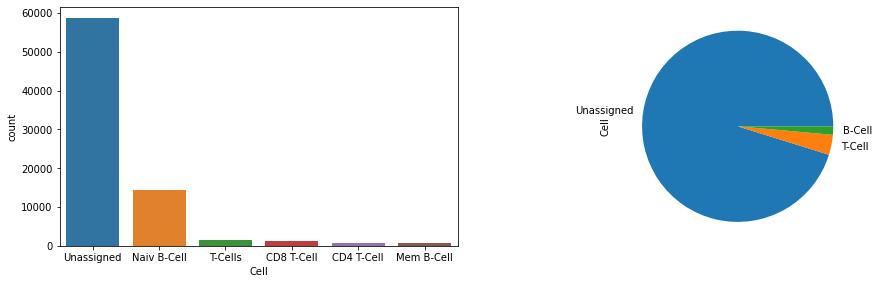

In [19]:
%matplotlib inline
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
fig.tight_layout(pad=5.0)
df1_temp['Cell'].value_counts().plot(kind='pie',ax=axs[1])
sns.countplot(x='Cell',data=df1,ax=axs[0])
plt.show()

In [20]:
df1_temp.to_csv("Cell_Predictions.csv")

# Evalution Section Only to Be Used for Manual Validation
## For using please uncomment and provide the list of cells encoded as integers

In [ ]:
# Provide Cell list in order
# = []

In [ ]:
# pred_bool = np.argmax(predictions, axis=1)
# target_names=['B-Cell','DC','Eosinophile','Monocyte','NK','Neutrophile','T-Cells','Unassigned']
# # Metrics
# print(classification_report(test_encoded, pred_bool,target_names=target_names))

# Confusion matrix

In [ ]:
# matrix_confusion = confusion_matrix(test_encoded, predictions.argmax(axis=1))

# # Normalise
# cmn = matrix_confusion.astype('float') / matrix_confusion.sum(axis=1)[:, np.newaxis]
# fig, axs = plt.subplots(ncols=3,figsize=(14, 7),gridspec_kw=dict(width_ratios=[12,12,0.5]))
# fig.tight_layout()

# sns.heatmap(matrix_confusion, annot=True, fmt='.0f',cbar=False, xticklabels=target_names, yticklabels=target_names,ax=axs[0])
# sns.heatmap(cmn, annot=True, fmt='.2f',cbar=False, xticklabels=target_names, yticklabels=target_names,ax=axs[1])
# fig.colorbar(axs[1].collections[0], cax=axs[2])
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show(block=False)

# ROC curve with auc

In [ ]:
# lw = 2

# lb = LabelBinarizer()
# lb.fit(test_encoded)
# y_true = lb.transform(test_encoded)
# y_pred = lb.transform(pred_bool)


# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
    
    

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# # Compute macro-average ROC curve and ROC area

# # First aggregate all false positive rates
# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# # Then interpolate all ROC curves at this points
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# # Finally average it and compute AUC
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# # Plot all ROC curves
# plt.figure(figsize=(10, 8))
# plt.plot(fpr["micro"], tpr["micro"],
#          label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue','crimson','darkred','darkolivegreen','violet','lightgreen'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label=f'ROC curve of {target_names[i]} (area = {roc_auc[i]:0.2f})')

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")

# plt.show()
